<a href="https://colab.research.google.com/github/HardeyPandya/Alphabet-Arrangement/blob/master/ising_rbm_scaling_rescaling_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import itertools as it
import numpy as np

class RBM(object):

    ''' Restricted Boltzmann Machine '''

    def __init__(self, num_hidden, num_visible, num_samples=128, weights=None, visible_bias=None, hidden_bias=None):
        ''' Constructor '''
        # number of hidden units
        self.num_hidden = num_hidden
        # number of visible units
        self.num_visible = num_visible

        # visible bias
        # default = tf.random_normal(shape=(self.num_visible, 1), mean=-0.5, stddev=0.05)
        default = tf.zeros(shape=(self.num_visible, 1))
        self.visible_bias = self._create_parameter_variable(visible_bias, default)
        # hidden bias
        # default = tf.random_normal(shape=(self.num_hidden, 1), mean=-0.2, stddev=0.05)
        default = tf.zeros(shape=(self.num_hidden, 1))
        self.hidden_bias = self._create_parameter_variable(hidden_bias, default)
        # pairwise weights
        default = tf.random.normal(shape=(self.num_visible, self.num_hidden), mean=0, stddev=0.05)
        #default = tf.zeros(shape=(self.num_visible, self.num_hidden))
        self.weights = self._create_parameter_variable(weights, default)

        # Variables for sampling.
        # number of samples to return when sample_p_of_v is called.
        self.num_samples = num_samples

        self.hidden_samples = tf.Variable(
            self.sample_binary_tensor(tf.constant(0.5), self.num_samples, self.num_hidden),
            trainable=False, name='hidden_samples'
        )
        self.obs_hid_samples= tf.Variable(
            self.sample_binary_tensor(tf.constant(0.5), self.num_samples, self.num_hidden),
            trainable=False, name='hidden_samples_obs'
        )

        self.p_of_v = None
        self._all_hidden_states = None
        self.max_feasible_for_log_pf = 24

    @property
    def all_hidden_states(self):
        ''' Build array with all possible configuration of the hidden layer '''
        if self._all_hidden_states is None:
            assert self.num_hidden <= self.max_feasible_for_log_pf, \
                'cannot generate all hidden states for num_hidden > {}'.format(self.max_feasible_for_log_pf)
            self._all_hidden_states = np.array(list(it.product([0, 1], repeat=self.num_hidden)), dtype=np.float32)
        return self._all_hidden_states

    @staticmethod
    def _create_parameter_variable(initial_value=None, default=None):
        ''' Initialize variables '''
        if initial_value is None:
            initial_value = default
        return tf.Variable(initial_value)


    def p_of_h_given(self, v):
        ''' Conditional probability of hidden layer given visible state '''
        # type: (tf.Tensor) -> tf.Tensor
        return tf.nn.sigmoid((tf.matmul(v, self.weights) + tf.transpose(self.hidden_bias)))

    def p_of_v_given(self, h):
        ''' Conditional probability of visible layer given hidden state '''
        # type: (tf.Tensor) -> tf.Tensor

        return tf.nn.sigmoid((tf.matmul(h, self.weights, transpose_b=True) + tf.transpose(self.visible_bias)))

    def sample_h_given(self, v):
        ''' Sample the hidden nodes given a visible state '''
        # type: (tf.Tensor) -> (tf.Tensor, tf.Tensor)
        b = tf.shape(v)[0]  # number of samples

        m = self.num_hidden
        prob_h = self.p_of_h_given(v)
        samples = self.sample_binary_tensor(prob_h, b, m)
        return samples, prob_h

    def sample_v_given(self, h):
        ''' Samples the visible nodes given a hidden state '''
        # type: (tf.Tensor) -> (tf.Tensor, tf.Tensor)
        b = tf.shape(h)[0]  # number of samples
        n = self.num_visible
        prob_v = self.p_of_v_given(h)
        samples = self.sample_binary_tensor(prob_v, b, n)
        return samples, prob_v

    def stochastic_maximum_likelihood(self, num_iterations):
        # type: (int) -> (tf.Tensor, tf.Tensor, tf.Tensor)
        """
        Define persistent CD_k. Stores the results of `num_iterations` of contrastive divergence in
        class variables.
        :param int num_iterations: The 'k' in CD_k.
        """
        h_samples = self.hidden_samples
        v_samples = None
        p_of_v = 0
        for i in range(num_iterations):
            v_samples, p_of_v = self.sample_v_given(h_samples)
            h_samples, _ = self.sample_h_given(v_samples)

        self.hidden_samples = h_samples
        self.p_of_v = p_of_v
        return self.hidden_samples, v_samples

    def observer_sampling(self, num_iterations):
        # type: (int) -> (tf.Tensor, tf.Tensor, tf.Tensor)
        """
        Define persistent CD_k. Stores the results of `num_iterations` of contrastive divergence in
        class variables.
        :param int num_iterations: The 'k' in CD_k.
        """
        h_samples = self.obs_hid_samples
        v_samples = None
        p_of_v = 0
        for i in range(num_iterations):
            v_samples, p_of_v = self.sample_v_given(h_samples)
            h_samples, _ = self.sample_h_given(v_samples)
        self.obs_hid_samples = self.obs_hid_samples.assign(h_samples)
        return v_samples

    def energy(self, hidden_samples, visible_samples):
        # type: (tf.Tensor, tf.Tensor) -> tf.Tensor
        """Compute the energy:
            E = - aT*v - bT*h - vT*W*h.

        Note that since we want to support larger batch sizes, we do element-wise multiplication between
        vT*W and h, and sum along the columns to get a Tensor of shape batch_size by 1

        :param hidden_samples: Tensor of shape batch_size by num_hidden
        :param visible_samples:  Tensor of shae batch_size by num_visible
        """
        return (-(tf.matmul(hidden_samples, self.hidden_bias))  # b x m * m x 1
                - tf.matmul(visible_samples, self.visible_bias)  # b x n * n x 1
                - tf.reduce_sum(tf.matmul(visible_samples, self.weights) * hidden_samples, 1))

    def free_energy(self, visible_samples):
        ''' Compute the free energy:
            F = aT*v + sum(softplus(a + vT*W)) '''
        free_energy = (tf.matmul(visible_samples, self.visible_bias)
                       + tf.reduce_sum(tf.nn.softplus(tf.matmul(visible_samples, self.weights)
                                                      + tf.transpose(self.hidden_bias)), 1, keepdims=True))
        return free_energy

    def neg_log_likelihood_grad(self, visible_samples, model_samples=None, num_gibbs=2):
        # type: (tf.Tensor, tf.Tensor, int) -> tf.Tensor
        hidden_samples, _ = self.sample_h_given(visible_samples)
        self.hidden_samples = hidden_samples
        expectation_from_data = tf.reduce_mean(self.energy(hidden_samples, visible_samples))
        model_hidden, model_visible = self.split_samples(model_samples) or self.stochastic_maximum_likelihood(num_gibbs)
        expectation_from_model = tf.reduce_mean(self.energy(model_hidden, model_visible))

        return expectation_from_data - expectation_from_model

    def neg_log_likelihood(self, visible_samples, log_Z):
        ''' Compute the average negative log likelihood over a batch of visible samples
            NLL = - <log(p(v))> = - <F> + log(Z) '''
        free_energy = ((tf.matmul(visible_samples, self.visible_bias))
                       + tf.reduce_sum(tf.nn.softplus((tf.matmul(visible_samples, self.weights)
                                                      + tf.transpose(self.hidden_bias))), 1))
        return -tf.reduce_mean(free_energy - log_Z)

    def exact_log_partition_function(self):
        ''' Evaluate the partition function by exact enumerations '''
        with tf.name_scope('exact_log_Z'):
            # Define the exponent: H*b + sum(softplus(1 + exp(a + w*H.T)))
            first_term = tf.matmul(self.all_hidden_states, self.hidden_bias, name='first_term')
            with tf.name_scope('second_term'):
                second_term = tf.matmul(self.weights, self.all_hidden_states, transpose_b=True)
                second_term = tf.nn.softplus(tf.add(self.visible_bias, second_term))
                second_term = tf.transpose(tf.reduce_sum(second_term, axis = 0, keepdims=True))
            exponent = tf.cast(first_term + second_term, dtype=tf.float64, name='exponent')
            #exponent_mean = tf.reduce_mean(exponent)
            exponent_mean = tf.reduce_max(exponent)

            return tf.math.log(tf.reduce_sum(tf.exp(exponent - exponent_mean))) + exponent_mean

    def split_samples(self, samples):
        if samples is None:
            return None

        visible_samples = tf.slice(samples, begin=(0, 0), size=(self.num_samples, self.num_visible))
        hidden_samples = tf.slice(samples, begin=(0, self.num_visible), size=(self.num_samples, self.num_hidden))
        return hidden_samples, visible_samples

    def set_weight_bias(self, weights1, visible_bias1, hidden_bias1):
        self.weights.assign(weights1)
        self.visible_bias.assign(visible_bias1)
        self.hidden_bias.assign(hidden_bias1)


    @staticmethod
    def sample_binary_tensor(prob, m, n):
        # type: (tf.Tensor, int, int) -> tf.Tensor
        """
        Convenience method for generating a binary Tensor using a given probability.

        :param prob: Tensor of shape (m, n)
        :param m: number of rows in result.
        :param n: number of columns in result.
        """
        return tf.where(
            tf.less(tf.random.uniform(shape=(m, n)), prob),
            tf.ones(shape=(m, n)),
            tf.zeros(shape=(m, n))
        )

In [ ]:
from __future__ import print_function
from pprint import pformat
import tensorflow as tf
import itertools as it
from random import randint
import sys
import numpy as np
import os
import json
import math as m
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
tf.disable_v2_behavior()

def save_parameters(sess, rbm, epochs,num_hidden,L,T):
    weights, visible_bias, hidden_bias = sess.run([rbm.weights, rbm.visible_bias, rbm.hidden_bias])
    parameter_file_path =  '/content/drive/MyDrive/data/ising1d/parameters/parameters_nH'+str(num_hidden) + '_L'+str(L)+'_T'+str(T)
    print('parameter_file_path saving...')
    np.savez_compressed(parameter_file_path, weights=weights, visible_bias=visible_bias, hidden_bias=hidden_bias,
                        epochs=epochs)

class Args(object):
    pass

class Placeholders(object):
    pass

class Ops(object):
    pass

def train(L=10,T=1.0,nH=4,steps=70000,bs=100,lr=1e-3,CD=10,nC=10,parameters_load=None):

    # Simulation parameters
    L=L
    T = T                      # temperature
    num_visible = L     # number of visible nodes
    num_hidden = nH            # number of hidden nodes
    nsteps = steps             # training steps
    bsize = bs                 # batch size
    learning_rate_b=lr         # learning rate
    num_gibbs = CD             # number of Gibbs iterations
    num_samples = nC           # number of chains in PCD
    weights=None                    # weights
    visible_bias=None               # visible bias
    hidden_bias=None                # hidden bias
    bcount=0                        # counter
    epochs_done=1                   # epochs counter

    # Loading the data
    train_dir = '/content/drive/MyDrive/data/ising1d'  # Location of training data.
    trainName = '/content/drive/MyDrive/data/ising1d/datasets/ising1d_L'+str(L)+'_T'+str(T)+'_train.txt'
    testName = '/content/drive/MyDrive/data/ising1d/datasets/ising1d_L'+str(L)+'_T'+str(T)+'_test.txt'
    xtrain = np.loadtxt(trainName)
    xtest = np.loadtxt(testName)

    ept=np.random.permutation(xtrain) # random permutation of training data
    epv=np.random.permutation(xtest) # random permutation of test data
    iterations_per_epoch = xtrain.shape[0] / bsize

    # Initialize RBM class
    rbm = RBM(num_hidden=num_hidden, num_visible=num_visible, weights=weights, visible_bias=visible_bias,hidden_bias=hidden_bias, num_samples=num_samples)

    # Initialize operations and placeholders classes
    ops = Ops()
    placeholders = Placeholders()
    placeholders.visible_samples = tf.placeholder(tf.float32, shape=(None, num_visible), name='v') # placeholder for training data

    total_iterations = 0 # starts at zero
    ops.global_step = tf.Variable(total_iterations, name='global_step_count', trainable=False)
    learning_rate = tf.train.exponential_decay(
        learning_rate_b,
        ops.global_step,
        100 * xtrain.shape[0]/bsize,
        1.0 # decay rate =1 means no decay
    )

    cost = rbm.neg_log_likelihood_grad(placeholders.visible_samples, num_gibbs=num_gibbs)
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-2)
    ops.lr=learning_rate
    ops.train = optimizer.minimize(cost, global_step=ops.global_step)
    ops.init = tf.group(tf.initialize_all_variables(), tf.initialize_local_variables())
    logZ = rbm.exact_log_partition_function()
    placeholders.logZ = tf.placeholder(tf.float32)
    NLL = rbm.neg_log_likelihood(placeholders.visible_samples,placeholders.logZ)


    placeholders.weights1 = tf.placeholder(tf.float32, shape=None, name='w')
    placeholders.visible_bias1 = tf.placeholder(tf.float32, shape=None, name='vb')
    placeholders.hidden_bias1 = tf.placeholder(tf.float32, shape=None, name='hb')

    p_x = tf.exp(rbm.free_energy(placeholders.visible_samples))
    all_v_states= np.array(list(it.product([0, 1], repeat=num_visible)), dtype=np.float32)

    # Observer file

    gibb_updates=10
    observer_samples=rbm.observer_sampling(gibb_updates)
    nbins=100

    # Build lattice
    #path_to_lattice = '/content/drive/MyDrive/CDL_RBM_Tutorial/data/ising2d/lattice2d_L'+str(args.L)+'.txt'
    #nn=np.loadtxt(path_to_lattice)

    e = np.zeros((num_samples))
    N = num_visible
    scaled_weight = rbm.weights.assign(placeholders.weights1)
    scaled_visible_bias = rbm.visible_bias.assign(placeholders.visible_bias1)
    scaled_hidden_bias = rbm.hidden_bias.assign(placeholders.hidden_bias1)

    nll1=np.array([])
    with tf.Session() as sess:

        if parameters_load == None:
          sess.run(ops.init)
          print('Hi!')


        else:
          sess.run(ops.init)

          print('Loading parameters...')
          path_to_params = parameters_load
          params = np.load(path_to_params)
          weights = params['weights']
          visible_bias = params['visible_bias']
          hidden_bias = params['hidden_bias']
          epochs_done = params['epochs']
          hidden_bias=np.reshape(hidden_bias,(hidden_bias.shape[0],1))
          visible_bias=np.reshape(visible_bias,(visible_bias.shape[0],1))

          rbm.set_weight_bias(placeholders.weights1,placeholders.visible_bias1,placeholders.hidden_bias1)
          sess.run([], feed_dict={placeholders.weights1:weights,placeholders.visible_bias1:visible_bias,placeholders.hidden_bias1:hidden_bias})


        for ii in range(nsteps):
            if bcount*bsize+ bsize>=xtrain.shape[0]:
               bcount=0
               ept=np.random.permutation(xtrain)

            batch=ept[ bcount*bsize: bcount*bsize+ bsize,:]
            #print(batch.shape)
            bcount=bcount+1
            feed_dict = {placeholders.visible_samples: batch}


            weights, visible_biases, hidden_biases = sess.run([rbm.weights, rbm.visible_bias, rbm.hidden_bias])
            #print('one {0}'.format(weights))

            weights = weights*T
            visible_biases = visible_biases*T
            hidden_biases = hidden_biases*T
            #print('three {0}'.format(weights))



            sess.run(scaled_weight, feed_dict={placeholders.weights1:weights})
            sess.run(scaled_visible_bias, feed_dict={placeholders.visible_bias1:visible_biases})
            sess.run(scaled_hidden_bias, feed_dict={placeholders.hidden_bias1:hidden_biases})

            _, num_steps = sess.run([ops.train, ops.global_step], feed_dict=feed_dict)



            weights, visible_biases, hidden_biases = sess.run([rbm.weights, rbm.visible_bias, rbm.hidden_bias])
            #print('two {0}'.format(weights)


            weights = weights/T
            visible_biases = visible_biases/T
            hidden_biases = hidden_biases/T



            sess.run(scaled_weight, feed_dict={placeholders.weights1:weights})
            sess.run(scaled_visible_bias, feed_dict={placeholders.visible_bias1:visible_biases})
            sess.run(scaled_hidden_bias, feed_dict={placeholders.hidden_bias1:hidden_biases})


            '''
            rbm.set_weight_bias(placeholders.weights1, placeholders.visible_bias1, placeholders.hidden_bias1)
            sess.run([], feed_dict={placeholders.weights1:weights, placeholders.visible_bias1:visible_bias, placeholders.hidden_bias1:hidden_bias})
            #sess.run([], feed_dict={placeholders.weights1:weights,placeholders.visible_bias1:visible_biases,placeholders.hidden_bias1:hidden_biases})
            #sess.run(rbm.set_weight_bias(placeholders.weights1,placeholders.visible_bias1,placeholders.hidden_bias1), feed_dict={placeholders.weights1:weights,placeholders.visible_bias1:visible_biases,placeholders.hidden_bias1:hidden_biases})
            '''


            if num_steps % iterations_per_epoch == 0:

                print ('Epoch = %d     ' % epochs_done,end='')
                lz = sess.run(logZ)

                nll = sess.run(NLL,feed_dict={placeholders.visible_samples: epv, placeholders.logZ: lz})
                px = sess.run(p_x,feed_dict={placeholders.visible_samples: all_v_states})
                print ('NLL = %.6f     ' % nll,end='')

                if epochs_done%10 == 0:    #After every 10 epochs, change temperature file
                    T = (T % 3)+1
                    print('Temperature file T={0}'.format(T))
                    train_dir = '/content/drive/MyDrive/data/ising1d'  # Location of training data.
                    trainName = '/content/drive/MyDrive/data/ising1d/datasets/ising1d_L'+str(L)+'_T'+str(T)+'_train.txt'
                    testName = '/content/drive/MyDrive/data/ising1d/datasets/ising1d_L'+str(L)+'_T'+str(T)+'_test.txt'
                    xtrain = np.loadtxt(trainName)
                    xtest = np.loadtxt(testName)
                    ept=np.random.permutation(xtrain) # random permutation of training data
                    epv=np.random.permutation(xtest) # random permutation of test data
                    save_parameters(sess, rbm,epochs_done,nH,L,T)



                '''
                for i in range(nbins):

                    # Gibbs sampling
                    samples=sess.run(observer_samples)
                    spins = np.asarray((2*samples-1))       #NOT SURE

                    # Compute averages of magnetizations
                    m_avg = np.mean(np.absolute(np.sum(spins,axis=1)))

                    # Compute averages of energies
                    e.fill(0.0)
                    for k in range(num_samples):
                        for i in range(N):
                            e[k] += -spins[k,i]*spins[k,((i+i)%N)]    #NOT SURE - MODIFIED
                    e_avg = np.mean(e)
                    E += (e_avg-E)/float(i+1)
                    M += (m_avg-M)/float(i+1)     #NOT SURE - MODIFIED

                # Print observer on screen
                #print ('Ov = %.6f     ' % Ov,end='')
                print ('NLL = %.6f     ' % nll,end='')
                print ('<E> = %.6f     ' % (E/float(N)),end='')
                print ('<|M|> = %.6f     ' % (M/float(N)),end='')
                '''
#T=3  -6.288689502308738
#T=2  -5.699440664472101
#T=1   -3.3352436543101307
                nll1 = np.append(nll1,nll)

                epochs_done += 1
                print(num_steps)

                if num_steps == nsteps:
                  print(num_steps)
                  px = sess.run(p_x,feed_dict={placeholders.visible_samples: all_v_states})
                  x = [*range(1<<num_visible)]
                  plt.plot(x,px/np.sum(px))
                  #plt.ylim(0,1)
                  plt.xlabel('Microstate')
                  plt.ylabel('Probability')
                  plt.ylim(0,0.02)
                  plt.title('Distribution obtained from trained RBM')
                  plt.show()
                  print(px/np.sum(px))

    T = T #Temperature
    J = 1.0 #interaction strength
    L=10
    all_configs = np.array(list(it.product([-1, 1], repeat=L)))

    print(all_configs[1023][2])
    microstate = np.zeros(1 << L)


    for j in range(1 << L):
      H=0
      for i in range(L):
        H = H - J*all_configs[j][i]*all_configs[j][(i+1)%L]   #periodic boudnary condition (i+1)%L
      microstate[j] = np.exp(-1.0/T * H)

    Z=0
    for i in range(1<<L):
      Z =Z+microstate[i]

    probability_of_microstate = np.zeros(1<<L)
    for j in range(1<<L):
      probability_of_microstate[j] = microstate[j]/Z

    x = [*range(1<<L)]

    plt.plot(x,probability_of_microstate,color='red')
    plt.ylim(0,0.02)
    plt.xlabel('Microstate')
    plt.ylabel('Probability')

    plt.title('Original Distribution')



    #plt.plot(np.asarray(list(range(epochs_done-1))),nll1)
    plt.show()
    plt.plot(np.asarray(list(range(epochs_done-1))),nll1)
    plt.xlabel('Epochs')
    plt.ylabel('NLL')
    plt.show()

    return epochs_done,nll,x,probability_of_microstate,(px/np.sum(px))


Instructions for updating:
non-resource variables are not supported in the long term


**TEST CODE**

In [ ]:
from __future__ import print_function
from pprint import pformat
import tensorflow as tf
import itertools as it
from random import randint
import sys
import numpy as np
import os
import json
import math as m
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
tf.disable_v2_behavior()

def save_parameters(sess, rbm, epochs,num_hidden,L,T):
    weights, visible_bias, hidden_bias = sess.run([rbm.weights, rbm.visible_bias, rbm.hidden_bias])
    parameter_file_path =  '/content/drive/MyDrive/data/ising1d/parameters/parameters_nH'+str(num_hidden) + '_L'+str(L)+'_T'+str(T)
    print('parameter_file_path saving...')
    np.savez_compressed(parameter_file_path, weights=weights, visible_bias=visible_bias, hidden_bias=hidden_bias,
                        epochs=epochs)

class Args(object):
    pass

class Placeholders(object):
    pass

class Ops(object):
    pass

def train(L=10,T=1.0,nH=4,steps=70000,bs=100,lr=1e-3,CD=10,nC=10,parameters_load=None):

    # Simulation parameters
    L=L
    T = T                      # temperature
    num_visible = L     # number of visible nodes
    num_hidden = nH            # number of hidden nodes
    nsteps = steps             # training steps
    bsize = bs                 # batch size
    learning_rate_b=lr         # learning rate
    num_gibbs = CD             # number of Gibbs iterations
    num_samples = nC           # number of chains in PCD
    weights=None                    # weights
    visible_bias=None               # visible bias
    hidden_bias=None                # hidden bias
    bcount=0                        # counter
    epochs_done=1                   # epochs counter

    # Loading the data
    train_dir = '/content/drive/MyDrive/data/ising1d'  # Location of training data.
    trainName = '/content/drive/MyDrive/data/ising1d/datasets/ising1d_L'+str(L)+'_T'+str(T)+'_train.txt'
    testName = '/content/drive/MyDrive/data/ising1d/datasets/ising1d_L'+str(L)+'_T'+str(T)+'_test.txt'
    xtrain = np.loadtxt(trainName)
    xtest = np.loadtxt(testName)

    ept=np.random.permutation(xtrain) # random permutation of training data
    epv=np.random.permutation(xtest) # random permutation of test data
    iterations_per_epoch = xtrain.shape[0] / bsize

    # Initialize RBM class
    rbm = RBM(num_hidden=num_hidden, num_visible=num_visible, weights=weights, visible_bias=visible_bias,hidden_bias=hidden_bias, num_samples=num_samples)

    # Initialize operations and placeholders classes
    ops = Ops()
    placeholders = Placeholders()
    placeholders.visible_samples = tf.placeholder(tf.float32, shape=(None, num_visible), name='v') # placeholder for training data

    total_iterations = 0 # starts at zero
    ops.global_step = tf.Variable(total_iterations, name='global_step_count', trainable=False)
    learning_rate = tf.train.exponential_decay(
        learning_rate_b,
        ops.global_step,
        100 * xtrain.shape[0]/bsize,
        1.0 # decay rate =1 means no decay
    )

    cost = rbm.neg_log_likelihood_grad(placeholders.visible_samples, num_gibbs=num_gibbs)
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-2)
    ops.lr=learning_rate
    ops.train = optimizer.minimize(cost, global_step=ops.global_step)
    ops.init = tf.group(tf.initialize_all_variables(), tf.initialize_local_variables())
    logZ = rbm.exact_log_partition_function()
    placeholders.logZ = tf.placeholder(tf.float32)
    NLL = rbm.neg_log_likelihood(placeholders.visible_samples,placeholders.logZ)


    placeholders.weights1 = tf.placeholder(tf.float32, shape=None, name='w')
    placeholders.visible_bias1 = tf.placeholder(tf.float32, shape=None, name='vb')
    placeholders.hidden_bias1 = tf.placeholder(tf.float32, shape=None, name='hb')

    p_x = tf.exp(rbm.free_energy(placeholders.visible_samples))
    all_v_states= np.array(list(it.product([0, 1], repeat=num_visible)), dtype=np.float32)

    # Observer file

    gibb_updates=10
    observer_samples=rbm.observer_sampling(gibb_updates)
    nbins=100

    # Build lattice
    #path_to_lattice = '/content/drive/MyDrive/CDL_RBM_Tutorial/data/ising2d/lattice2d_L'+str(args.L)+'.txt'
    #nn=np.loadtxt(path_to_lattice)

    e = np.zeros((num_samples))
    N = num_visible
    scaled_weight = rbm.weights.assign(placeholders.weights1)
    scaled_visible_bias = rbm.visible_bias.assign(placeholders.visible_bias1)
    scaled_hidden_bias = rbm.hidden_bias.assign(placeholders.hidden_bias1)

    nll1=np.array([])
    with tf.Session() as sess:

        if parameters_load == None:
          sess.run(ops.init)
          print('Hi!')


        else:
          sess.run(ops.init)

          print('Loading parameters...')
          path_to_params = parameters_load
          params = np.load(path_to_params)
          weights = params['weights']
          visible_bias = params['visible_bias']
          hidden_bias = params['hidden_bias']
          epochs_done = params['epochs']
          hidden_bias=np.reshape(hidden_bias,(hidden_bias.shape[0],1))
          visible_bias=np.reshape(visible_bias,(visible_bias.shape[0],1))

          rbm.set_weight_bias(placeholders.weights1,placeholders.visible_bias1,placeholders.hidden_bias1)
          sess.run([], feed_dict={placeholders.weights1:weights,placeholders.visible_bias1:visible_bias,placeholders.hidden_bias1:hidden_bias})


        for ii in range(nsteps):
            if bcount*bsize+ bsize>=xtrain.shape[0]:
               bcount=0
               ept=np.random.permutation(xtrain)

            batch=ept[ bcount*bsize: bcount*bsize+ bsize,:]
            #print(batch.shape)
            bcount=bcount+1
            feed_dict = {placeholders.visible_samples: batch}


            weights, visible_biases, hidden_biases = sess.run([rbm.weights, rbm.visible_bias, rbm.hidden_bias])
            #print('one {0}'.format(weights))

            weights = weights*T
            visible_biases = visible_biases*T
            hidden_biases = hidden_biases*T
            #print('three {0}'.format(weights))



            sess.run(scaled_weight, feed_dict={placeholders.weights1:weights})
            sess.run(scaled_visible_bias, feed_dict={placeholders.visible_bias1:visible_biases})
            sess.run(scaled_hidden_bias, feed_dict={placeholders.hidden_bias1:hidden_biases})

            _, num_steps = sess.run([ops.train, ops.global_step], feed_dict=feed_dict)



            weights, visible_biases, hidden_biases = sess.run([rbm.weights, rbm.visible_bias, rbm.hidden_bias])
            #print('two {0}'.format(weights)


            weights = weights/T
            visible_biases = visible_biases/T
            hidden_biases = hidden_biases/T



            sess.run(scaled_weight, feed_dict={placeholders.weights1:weights})
            sess.run(scaled_visible_bias, feed_dict={placeholders.visible_bias1:visible_biases})
            sess.run(scaled_hidden_bias, feed_dict={placeholders.hidden_bias1:hidden_biases})


            '''
            rbm.set_weight_bias(placeholders.weights1, placeholders.visible_bias1, placeholders.hidden_bias1)
            sess.run([], feed_dict={placeholders.weights1:weights, placeholders.visible_bias1:visible_bias, placeholders.hidden_bias1:hidden_bias})
            #sess.run([], feed_dict={placeholders.weights1:weights,placeholders.visible_bias1:visible_biases,placeholders.hidden_bias1:hidden_biases})
            #sess.run(rbm.set_weight_bias(placeholders.weights1,placeholders.visible_bias1,placeholders.hidden_bias1), feed_dict={placeholders.weights1:weights,placeholders.visible_bias1:visible_biases,placeholders.hidden_bias1:hidden_biases})
            '''


            if num_steps % iterations_per_epoch == 0:

                print ('Epoch = %d     ' % epochs_done,end='')
                lz = sess.run(logZ)

                nll = sess.run(NLL,feed_dict={placeholders.visible_samples: epv, placeholders.logZ: lz})
                px = sess.run(p_x,feed_dict={placeholders.visible_samples: all_v_states})
                print ('NLL = %.6f     ' % nll,end='')

                if epochs_done%10 == 0:    #After every 10 epochs, change temperature file
                    T = (T % 3)+1
                    print('Temperature file T={0}'.format(T))
                    train_dir = '/content/drive/MyDrive/data/ising1d'  # Location of training data.
                    trainName = '/content/drive/MyDrive/data/ising1d/datasets/ising1d_L'+str(L)+'_T'+str(T)+'_train.txt'
                    testName = '/content/drive/MyDrive/data/ising1d/datasets/ising1d_L'+str(L)+'_T'+str(T)+'_test.txt'
                    xtrain = np.loadtxt(trainName)
                    xtest = np.loadtxt(testName)
                    ept=np.random.permutation(xtrain) # random permutation of training data
                    epv=np.random.permutation(xtest) # random permutation of test data
                    save_parameters(sess, rbm,epochs_done,nH,L,T)



                '''
                for i in range(nbins):

                    # Gibbs sampling
                    samples=sess.run(observer_samples)
                    spins = np.asarray((2*samples-1))       #NOT SURE

                    # Compute averages of magnetizations
                    m_avg = np.mean(np.absolute(np.sum(spins,axis=1)))

                    # Compute averages of energies
                    e.fill(0.0)
                    for k in range(num_samples):
                        for i in range(N):
                            e[k] += -spins[k,i]*spins[k,((i+i)%N)]    #NOT SURE - MODIFIED
                    e_avg = np.mean(e)
                    E += (e_avg-E)/float(i+1)
                    M += (m_avg-M)/float(i+1)     #NOT SURE - MODIFIED

                # Print observer on screen
                #print ('Ov = %.6f     ' % Ov,end='')
                print ('NLL = %.6f     ' % nll,end='')
                print ('<E> = %.6f     ' % (E/float(N)),end='')
                print ('<|M|> = %.6f     ' % (M/float(N)),end='')
                '''
#T=3  -6.288689502308738
#T=2  -5.699440664472101
#T=1   -3.3352436543101307
                nll1 = np.append(nll1,nll)

                epochs_done += 1
                print(num_steps)

                if num_steps == nsteps:
                  print(num_steps)
                  px = sess.run(p_x,feed_dict={placeholders.visible_samples: all_v_states})
                  x = [*range(1<<num_visible)]
                  plt.plot(x,px/np.sum(px))
                  #plt.ylim(0,1)
                  plt.xlabel('Microstate')
                  plt.ylabel('Probability')
                  plt.ylim(0,0.02)
                  plt.title('Distribution obtained from trained RBM')
                  plt.show()
                  print(px/np.sum(px))

    T = T #Temperature
    J = 1.0 #interaction strength
    L=10
    all_configs = np.array(list(it.product([-1, 1], repeat=L)))

    print(all_configs[1023][2])
    microstate = np.zeros(1 << L)


    for j in range(1 << L):
      H=0
      for i in range(L):
        H = H - J*all_configs[j][i]*all_configs[j][(i+1)%L]   #periodic boudnary condition (i+1)%L
      microstate[j] = np.exp(-1.0/T * H)

    Z=0
    for i in range(1<<L):
      Z =Z+microstate[i]

    probability_of_microstate = np.zeros(1<<L)
    for j in range(1<<L):
      probability_of_microstate[j] = microstate[j]/Z

    x = [*range(1<<L)]

    plt.plot(x,probability_of_microstate,color='red')
    plt.ylim(0,0.02)
    plt.xlabel('Microstate')
    plt.ylabel('Probability')

    plt.title('Original Distribution')



    #plt.plot(np.asarray(list(range(epochs_done-1))),nll1)
    plt.show()
    plt.plot(np.asarray(list(range(epochs_done-1))),nll1)
    plt.xlabel('Epochs')
    plt.ylabel('NLL')
    plt.show()

    return epochs_done,nll,x,probability_of_microstate,(px/np.sum(px))


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.local_variables_initializer` instead.


Hi!
Epoch = 1     NLL = 6.988922     50
Epoch = 2     NLL = 7.211286     100
Epoch = 3     NLL = 8.982667     150
Epoch = 4     NLL = 20.418570     200
Epoch = 5     NLL = 60.178719     250
Epoch = 6     NLL = 180.099579     300
Epoch = 7     NLL = 539.524902     350
Epoch = 8     NLL = 1617.678589     400
Epoch = 9     NLL = 4852.086426     450
Epoch = 10     NLL = 14555.305664     Temperature file T=1.0
parameter_file_path saving...
500
Epoch = 11     NLL = 15355.177734     550
Epoch = 12     NLL = 15354.062500     600
Epoch = 13     NLL = 15353.001953     650
Epoch = 14     NLL = 15351.979492     700
Epoch = 15     NLL = 15350.995117     750
Epoch = 16     NLL = 15350.028320     800
Epoch = 17     NLL = 15349.084961     850
Epoch = 18     NLL = 15348.132812     900
Epoch = 19     NLL = 15347.190430     950
Epoch = 20     NLL = 15346.252930     Temperature file T=2.0
parameter_file_path saving...
1000
Epoch = 21     NLL = 27946.330078     1050
Epoch = 22     NLL = 55891.738281     11

<ipython-input-2-3038186c751e>:149: RuntimeWarning: overflow encountered in multiply
  weights = weights*T


Epoch = 152     NLL = nan     7600
Epoch = 153     NLL = nan     7650


<ipython-input-2-3038186c751e>:150: RuntimeWarning: overflow encountered in multiply
  visible_biases = visible_biases*T
<ipython-input-2-3038186c751e>:151: RuntimeWarning: overflow encountered in multiply
  hidden_biases = hidden_biases*T


Epoch = 154     NLL = nan     7700
Epoch = 155     NLL = nan     7750
Epoch = 156     NLL = nan     7800
Epoch = 157     NLL = nan     7850
Epoch = 158     NLL = nan     7900
Epoch = 159     NLL = nan     7950
Epoch = 160     NLL = nan     Temperature file T=1.0
parameter_file_path saving...
8000
Epoch = 161     NLL = nan     8050
Epoch = 162     NLL = nan     8100
Epoch = 163     NLL = nan     8150
Epoch = 164     NLL = nan     8200
Epoch = 165     NLL = nan     8250
Epoch = 166     NLL = nan     8300
Epoch = 167     NLL = nan     8350
Epoch = 168     NLL = nan     8400
Epoch = 169     NLL = nan     8450
Epoch = 170     NLL = nan     Temperature file T=2.0
parameter_file_path saving...
8500
Epoch = 171     NLL = nan     8550
Epoch = 172     NLL = nan     8600
Epoch = 173     NLL = nan     8650
Epoch = 174     NLL = nan     8700
Epoch = 175     NLL = nan     8750
Epoch = 176     NLL = nan     8800
Epoch = 177     NLL = nan     8850
Epoch = 178     NLL = nan     8900
Epoch = 179     NLL

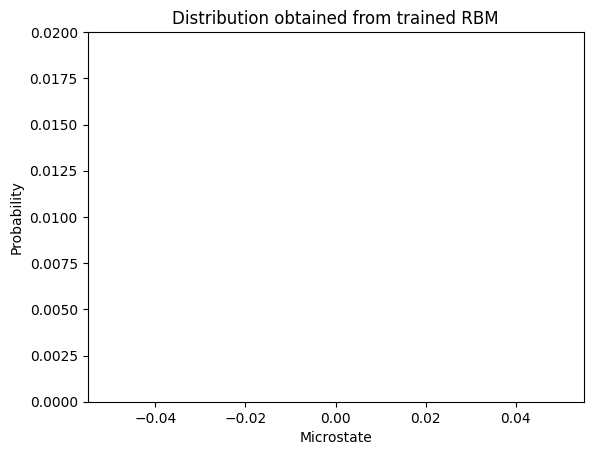

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
1


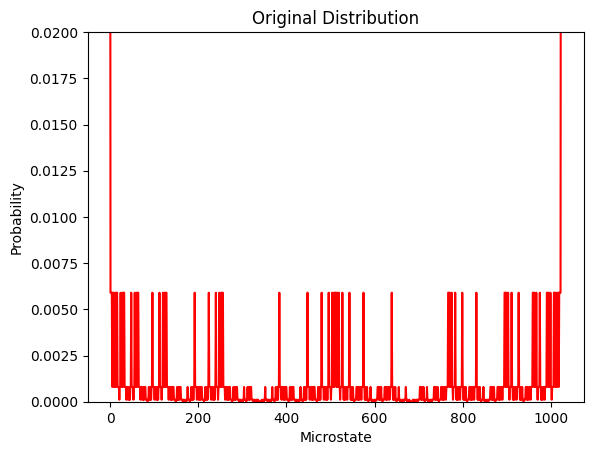

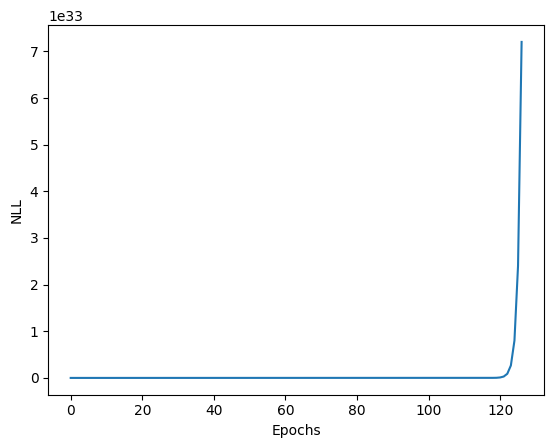

In [ ]:
sinepochs_done,nll1,x,probability_of_microstate,px = train(T=3.0, nH=6,L=10,CD=3)